In [2]:
%matplotlib inline

import numpy as np
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import pandas as pd
from matplotlib import pyplot as plt

In [3]:
import tensorflow
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils

In [4]:
import sklearn.neighbors._base
import sys

sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [5]:
from collections import Counter
from sklearn.datasets import make_classification

from imblearn.over_sampling import SMOTE

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

In [6]:
x_or_predict = pd.read_csv(r"C:\Users\lucam\Desktop\Uni\Advanced Machine Learning\Assignment 1\X_test.csv")
x_split = pd.read_csv(r"C:\Users\lucam\Desktop\Uni\Advanced Machine Learning\Assignment 1\X_train.csv")
y_split = pd.read_csv(r"C:\Users\lucam\Desktop\Uni\Advanced Machine Learning\Assignment 1\Y_train.csv")

# Predicting Default Payments with Fully-Connected NNs

The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. 

## Inspecting the data

any comment about data dimensionality/distribution goes here

### Comment
The dataset is composed by 24 variables and 24 000 observations. Qualitative speaking all data are in the right form, all 'yes/no' labels have alredy been replaced by numerical '0/1' labels.  
The second dataset, the one to be used for predictions, has 6 000 observations.  
All the 24 variables but one are usefull for a proper prediction, the exception being column 'ID' that shall be removed later.  
The dataset is imbalanced, in particular the positive class is in a 3.5:1 ratio to the negative class. In order to correct this a resampling procedure on the training set will be adopted, consisting in an oversampling of the lesser represented class. 

In [7]:
x_split

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,21754,80000.0,2,2,2,24,0,0,0,0,...,78321.0,73731.0,39643.0,39457.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0
1,252,30000.0,1,2,2,28,0,0,0,0,...,29155.0,25255.0,22001.0,0.0,5006.0,1244.0,851.0,955.0,0.0,0.0
2,22942,180000.0,2,5,1,44,0,0,-1,-1,...,850.0,0.0,6881.0,10340.0,0.0,850.0,0.0,6881.0,10340.0,182.0
3,619,60000.0,1,1,2,25,0,0,0,0,...,38533.0,39639.0,39619.0,39140.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0
4,17091,130000.0,2,2,2,25,0,0,0,0,...,114734.0,117823.0,120854.0,123904.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,29803,50000.0,1,2,2,32,0,0,0,0,...,55739.0,55957.0,29238.0,6119.0,2000.0,3000.0,1591.0,72.0,1134.0,73421.0
23996,5391,200000.0,1,1,2,37,2,2,2,2,...,168386.0,164182.0,169029.0,172084.0,13500.0,6000.0,0.0,7500.0,6000.0,4000.0
23997,861,50000.0,1,1,2,26,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23998,15796,70000.0,2,2,2,25,0,0,0,0,...,51152.0,35122.0,28633.0,28039.0,3000.0,2000.0,4500.0,1200.0,0.0,1200.0


In [8]:
x_or_predict

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,2309,30000.0,1,2,2,25,0,0,0,0,...,11581.0,12580.0,13716.0,14828.0,1500.0,2000.0,1500.0,1500.0,1500.0,2000.0
1,22405,150000.0,2,1,2,26,0,0,0,0,...,116684.0,101581.0,77741.0,77264.0,4486.0,4235.0,3161.0,2647.0,2669.0,2669.0
2,23398,70000.0,2,3,1,32,0,0,0,0,...,68530.0,69753.0,70111.0,70212.0,2431.0,3112.0,3000.0,2438.0,2500.0,2554.0
3,25059,130000.0,1,3,2,49,0,0,0,0,...,16172.0,16898.0,11236.0,6944.0,1610.0,1808.0,7014.0,27.0,7011.0,4408.0
4,2665,50000.0,2,2,2,36,0,0,0,0,...,42361.0,19574.0,20295.0,19439.0,2000.0,1500.0,1000.0,1800.0,0.0,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2211,360000.0,2,1,2,27,1,-2,-1,-1,...,830.0,0.0,1271.0,179.0,0.0,830.0,0.0,1271.0,179.0,1970.0
5996,14145,500000.0,2,1,2,28,2,0,0,2,...,111690.0,78070.0,78376.0,80912.0,6000.0,13151.0,0.0,3000.0,5000.0,10000.0
5997,23109,60000.0,2,1,1,28,0,0,0,0,...,48696.0,50385.0,52045.0,52661.0,2100.0,2500.0,2500.0,2500.0,1600.0,1500.0
5998,25704,20000.0,2,1,2,29,1,-1,-1,-1,...,3967.0,1364.0,600.0,0.0,2494.0,3967.0,1370.0,600.0,0.0,0.0


In [378]:
y_split['default.payment.next.month'].value_counts()

0    18677
1     5323
Name: default.payment.next.month, dtype: int64

## Preparing the data

describe the choice made during the preprocessing operations, also taking into account the previous considerations during the data inspection.

### Comment
In order to prepare the data the first step is to remove the useless column 'ID' from all the datasets available. After that all the numerical data are set as 'float32', just to be sure python treats them all equally.  
In preparation to the evaluation phase the training dataset, composed by x_split and y_split, is splitted into a train and a test subset (90% training and 10% test).   
After that the resampling procedure on the training data takes place through the SMOTE package. The minority class is taken as a base for the resampling and, after that, the training dataset appears to be balanced, with 16 827 observations for each class.  
The last step in the preparation phase is to normalize all the data that later will be passed to the model. This is done in order to speed up the learning procedure and to achieve better performances. In this case a min-max scaler is used.

In [381]:
x_split = x_split.drop('ID', axis = 'columns')
x_predict = x_or_predict.drop('ID', axis = 'columns')
y_split = y_split.drop('ID', axis = 'columns')

In [382]:
x_split = x_split.astype('float32')
x_predict = x_predict.astype('float32')
y_split = y_split.astype('float32')

In [383]:
x_train, x_test, y_train, y_test = train_test_split(x_split, y_split, test_size=0.1, random_state=0)

In [384]:
y_train = y_train['default.payment.next.month']
over = SMOTE(sampling_strategy= 'minority')
x_train, y_train = over.fit_resample(x_train, y_train)

In [385]:
y_train.value_counts()

0.0    16827
1.0    16827
Name: default.payment.next.month, dtype: int64

In [386]:
scaler = preprocessing.MinMaxScaler((-1,1))
scaler.fit(x_split)

x_train = scaler.transform(x_train.values)
x_test  = scaler.transform(x_test.values) 
y_train = y_train.values 
y_test  = y_test.values 

In [387]:
scaler.fit(x_predict)
x_predict = scaler.transform(x_predict.values)

## Building the network

any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. optimizer choice, final activations, loss functions, training metrics)

### Comment
Both the task of the assignment and the nature of the dataset at hand are crucial in order to decide the proper number of layers the final neural network should have.  
Considering the small amount of varibles and observations in the data and the necessity to perform a simple binary classification two kind of models have been tested; a neural network with only a single hidden layer and its simple extension with a second hidden layer. A configuration with more layers is to be considered unnecessarily complicated for this occasion.  
The next step is to determine how many nodes our network should have in each layer. This task is assigned to a grid search cross validation. Thanks to the GridSearchCV package, each model configuration is tested and the configuration with the best value for the model accuracy is chosen. Again, given the simplicity of the task and the small dataset, the number of nodes evaluated was from 10 to 70 in each layer (with a step size of 10 nodes at each iteration). This procedure determined that a value of 50 nodes for the first hidden layer in both networks and 10 nodes for the second hidden layer in the latter model is to be considered the best.  
On the other hand the input layer is set with 23 nodes, corresponding to the number of features, and the last layer with one node, as it is usual for a binary classification.  

More in details, a stochastic gradient descent procedure is used as an optimizer. Later it will be employed in its mini-batch variant, mainly due to computational reasons. It is worth noting, though, that given the limited amount of observations in the dataset this is not deemed as strictly necessary.  
Having to deal with a binary classification problem the loss function and the activation function in the final layer have been respectively chosen as a binary cross entropy and a sigmoid. Binary cross entropy is one of the best loss functions for this kind of problems, while the sigmoid is a function designed to output a probability value between 0 and 1 for each observation, exactly what is needed in this situation.  
As an activation function for each hidden layer a simple ReLu function has been employed. This is the default option for most neural networks, in fact it proved itself to be very reliable in most cases, at leat empirically. As a note, in this particular setting a sigmoid function could have been used as an activator for the hidden layers as well.  

Last but not least the accuracy of the model is taken as a training metric. It is used to calculate the overall percentage of observations that are correctly classified by the model. 

In [389]:
x_train.shape

(33654, 23)

In [20]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(neurons=1):
    model_cv = Sequential()
    model_cv.add(Dense(neurons, activation= "relu", input_shape=(23,)))
    model_cv.add(Dense(1, activation = "sigmoid"))
    
    model_cv.compile(optimizer = "sgd",
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"]
                  )
    return model_cv

model_cv = KerasClassifier(build_fn=create_model, epochs=100, batch_size=26, verbose=0)
# define the grid search parameters
neurons = [10, 20, 30, 40, 50, 60, 70]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model_cv, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.727046 using {'neurons': 50}
0.600166 (0.135028) with: {'neurons': 10}
0.653176 (0.176496) with: {'neurons': 20}
0.670945 (0.152446) with: {'neurons': 30}
0.678344 (0.150615) with: {'neurons': 40}
0.727046 (0.104275) with: {'neurons': 50}
0.685060 (0.098338) with: {'neurons': 60}
0.683574 (0.124829) with: {'neurons': 70}


In [365]:
model = Sequential()
#1 layer
model.add(Dense(50, activation= "relu", input_shape=(23,)))

# output layer
model.add(Dense(1, activation = "sigmoid"))


# compile: optimizer & losses/metrics
model.compile(optimizer = "sgd",
              loss = "binary_crossentropy",
              metrics = ["accuracy"]
              )

In [366]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 50)                1200      
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 51        
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [391]:
def create_model(neurons_1= 1, neurons_2 = 1):
    model_cv = Sequential()
    model_cv.add(Dense(neurons_1, activation= "relu", input_shape=(23,)))
    model_cv.add(Dense(neurons_2, activation= "relu"))
    model_cv.add(Dense(1, activation = "sigmoid"))
    
    model_cv.compile(optimizer = "sgd",
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"]
                  )
    return model_cv

model_cv = KerasClassifier(build_fn=create_model, epochs=100, batch_size=26, verbose=0)


neurons = [10, 20, 30, 40, 50, 60, 70]
param_grid = dict(neurons_1=neurons, neurons_2=neurons)
grid = GridSearchCV(estimator=model_cv, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.754591 using {'neurons_1': 50, 'neurons_2': 10}
0.696351 (0.078522) with: {'neurons_1': 10, 'neurons_2': 10}
0.571819 (0.110991) with: {'neurons_1': 10, 'neurons_2': 20}
0.596422 (0.059481) with: {'neurons_1': 10, 'neurons_2': 30}
0.715190 (0.045601) with: {'neurons_1': 10, 'neurons_2': 40}
0.740061 (0.081755) with: {'neurons_1': 10, 'neurons_2': 50}
0.629227 (0.147373) with: {'neurons_1': 10, 'neurons_2': 60}
0.624710 (0.150527) with: {'neurons_1': 10, 'neurons_2': 70}
0.660516 (0.100503) with: {'neurons_1': 20, 'neurons_2': 10}
0.652463 (0.133018) with: {'neurons_1': 20, 'neurons_2': 20}
0.705949 (0.084787) with: {'neurons_1': 20, 'neurons_2': 30}
0.648600 (0.183331) with: {'neurons_1': 20, 'neurons_2': 40}
0.696916 (0.077135) with: {'neurons_1': 20, 'neurons_2': 50}
0.724580 (0.103981) with: {'neurons_1': 20, 'neurons_2': 60}
0.696648 (0.110774) with: {'neurons_1': 20, 'neurons_2': 70}
0.727818 (0.099938) with: {'neurons_1': 30, 'neurons_2': 10}
0.660100 (0.106958) with: {'n

In [390]:
model_1 = Sequential()
#1 layer
model_1.add(Dense(50, activation= "relu", input_shape=(23,)))
#2 layer
model_1.add(Dense(10, activation= "relu"))

# output layer
model_1.add(Dense(1, activation = "sigmoid"))


# compile: optimizer & losses/metrics
model_1.compile(optimizer = "sgd",
              loss = "binary_crossentropy",
              metrics = ["accuracy"]
              )

In [391]:
model_1.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 50)                1200      
_________________________________________________________________
dense_74 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 11        
Total params: 1,721
Trainable params: 1,721
Non-trainable params: 0
_________________________________________________________________


## Analyze and comment the training results

here goes any comment/visualization of the training history and any initial consideration on the training results  

### Comment
As previously mentioned the mini batch variation of the gradient descent is used in the fitting phase. In particular the selected batch size is 78 and this gives 431 batches to be used to adjust the weights of the model.  
In order to determine the number of epochs to be employed an early stopping procedure is implemented. In general more epochs are used, more a model can overfit the data. To avoid this possible problem the package EarlyStopping provides a way to halt the fitting procedure. Generally this happens once adding a new epoch does not provide any improvement anymore to the parameter monitored (loss function of the validation set). In this case, however, a patience level of 20 is used. Therefore, in order for the fitting procedure to be halted, 20 consecutives epochs must not grant any improvement. This is done in order to avoid possible plateau of just a couple of low-improvement epochs, followed by a new improvement period.  
The model with only one layer stops at 129 epochs, while the other model at just 83.  
As the following plots show both models can achieve a pretty high accuracy, generally over 70%.  
Both models suffer from overfitting the data too, although in this regard using only one hidden layer definitely provides better results. Looking at the plots it is pretty clear that the second model has a lot of extra noise and, in general, suffers from higher overfitting.  
Besides models plots, two additional figures are provided. This are used to show the effect that a highter number of epochs can have on a model. For the first model 200 epochs were used, while for the second 150. It is obvious how in this way even more overfitting is produced in both the cases.  

In [369]:
es = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20) # 20 epochs without improvement before the fitting stops
batch_size = 78 #431 batches
history = model.fit(x_train, y_train, epochs=1000, batch_size=batch_size, validation_split = 0.2, callbacks=[es]) # 20% validation
stopped = es.stopped_epoch

Epoch 1/1000
346/346 [==============================] - 1s 1ms/step - loss: 0.6613 - accuracy: 0.6110 - val_loss: 0.9540 - val_accuracy: 0.0303
Epoch 2/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.6343 - accuracy: 0.6424 - val_loss: 0.8960 - val_accuracy: 0.1554
Epoch 3/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.6201 - accuracy: 0.6697 - val_loss: 0.8855 - val_accuracy: 0.2527
Epoch 4/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.6099 - accuracy: 0.6948 - val_loss: 0.9222 - val_accuracy: 0.2723
Epoch 5/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.6019 - accuracy: 0.7073 - val_loss: 0.8684 - val_accuracy: 0.3707
Epoch 6/1000
346/346 [==============================] - 1s 1ms/step - loss: 0.5953 - accuracy: 0.7182 - val_loss: 0.8856 - val_accuracy: 0.3736
Epoch 7/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.5906 - accuracy: 0.7236 - val_loss: 0.8852 - val_accuracy:

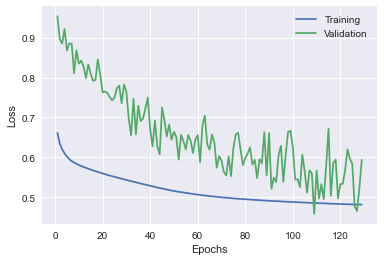

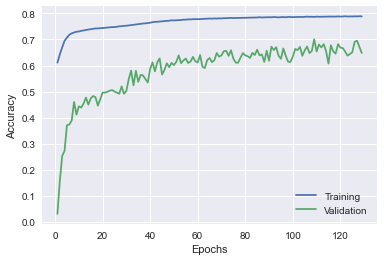

In [370]:
from matplotlib import pyplot as plt
x_plot = list(range(1,stopped+2))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()


plot_history(history)

In [92]:
# example with 200 epochs, first model
history = model.fit(x_train, y_train, epochs=200, batch_size=batch_size, validation_split = 0.2)

Epoch 1/200
346/346 [==============================] - 1s 1ms/step - loss: 0.6591 - accuracy: 0.6141 - val_loss: 0.9320 - val_accuracy: 0.0507
Epoch 2/200
346/346 [==============================] - 0s 871us/step - loss: 0.6220 - accuracy: 0.6646 - val_loss: 0.9352 - val_accuracy: 0.1905
Epoch 3/200
346/346 [==============================] - 0s 877us/step - loss: 0.6056 - accuracy: 0.7029 - val_loss: 0.8951 - val_accuracy: 0.3185
Epoch 4/200
346/346 [==============================] - 0s 868us/step - loss: 0.5959 - accuracy: 0.7194 - val_loss: 0.8613 - val_accuracy: 0.3820
Epoch 5/200
346/346 [==============================] - 0s 912us/step - loss: 0.5894 - accuracy: 0.7277 - val_loss: 0.8144 - val_accuracy: 0.4329
Epoch 6/200
346/346 [==============================] - 0s 830us/step - loss: 0.5845 - accuracy: 0.7315 - val_loss: 0.8430 - val_accuracy: 0.4102
Epoch 7/200
346/346 [==============================] - 0s 905us/step - loss: 0.5802 - accuracy: 0.7350 - val_loss: 0.8864 - val_accu

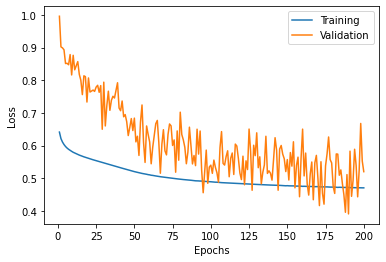

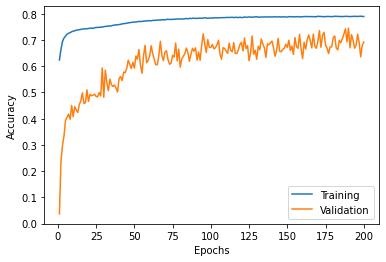

In [61]:
from matplotlib import pyplot as plt
x_plot = list(range(1,n_epochs+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()


plot_history(history)

# Entrambe l'accuratezza di training e validation sta ancora salendo e la loss sta scendendo <-- ho bisogno di più epoche
# valòidazione con molto rumore <-- cambio batch size

In [392]:
history_1 = model_1.fit(x_train, y_train, epochs=1000, batch_size=batch_size, validation_split = 0.2, callbacks=[es])
stopped = es.stopped_epoch

Epoch 1/1000
346/346 [==============================] - 1s 1ms/step - loss: 0.6443 - accuracy: 0.6199 - val_loss: 0.9042 - val_accuracy: 0.0715
Epoch 2/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.6168 - accuracy: 0.6672 - val_loss: 0.9082 - val_accuracy: 0.2266
Epoch 3/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.6006 - accuracy: 0.7074 - val_loss: 0.7970 - val_accuracy: 0.4447
Epoch 4/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.5904 - accuracy: 0.7266 - val_loss: 0.8616 - val_accuracy: 0.4096
Epoch 5/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.5837 - accuracy: 0.7339 - val_loss: 0.8662 - val_accuracy: 0.4213
Epoch 6/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.5790 - accuracy: 0.7374 - val_loss: 0.8834 - val_accuracy: 0.4206
Epoch 7/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.5755 - accuracy: 0.7396 - val_loss: 0.8389 - val_accuracy:

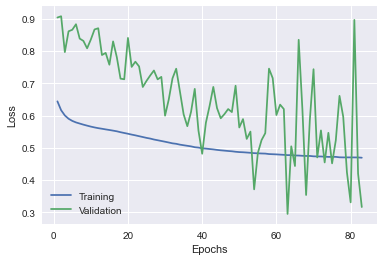

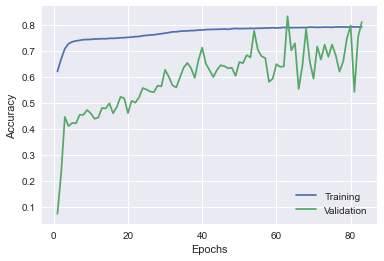

In [393]:
from matplotlib import pyplot as plt
x_plot = list(range(1,stopped+2))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()


plot_history(history_1)

# overfitting

In [138]:
# example with 150 epochs, first model
history_1 = model_1.fit(x_train, y_train, epochs=150, batch_size=batch_size, validation_split = 0.2) # 20% validation

Epoch 1/150
346/346 [==============================] - 1s 1ms/step - loss: 0.6593 - accuracy: 0.6081 - val_loss: 0.9321 - val_accuracy: 0.0100
Epoch 2/150
346/346 [==============================] - 0s 919us/step - loss: 0.6358 - accuracy: 0.6329 - val_loss: 0.9353 - val_accuracy: 0.0495
Epoch 3/150
346/346 [==============================] - 0s 945us/step - loss: 0.6200 - accuracy: 0.6649 - val_loss: 0.8793 - val_accuracy: 0.2340
Epoch 4/150
346/346 [==============================] - 0s 937us/step - loss: 0.6046 - accuracy: 0.6987 - val_loss: 0.8684 - val_accuracy: 0.3465
Epoch 5/150
346/346 [==============================] - 0s 948us/step - loss: 0.5917 - accuracy: 0.7203 - val_loss: 0.8029 - val_accuracy: 0.4467
Epoch 6/150
346/346 [==============================] - 0s 1ms/step - loss: 0.5815 - accuracy: 0.7291 - val_loss: 0.8044 - val_accuracy: 0.4506
Epoch 7/150
346/346 [==============================] - 0s 1ms/step - loss: 0.5736 - accuracy: 0.7339 - val_loss: 0.7894 - val_accuracy

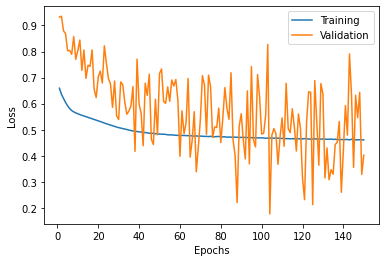

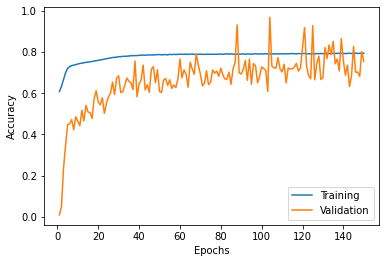

In [139]:
from matplotlib import pyplot as plt
x_plot = list(range(1,150+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()


plot_history(history_1)


## Validate the model and comment the results

please describe the evaluation procedure on a validation set, commenting the generalization capability of your model (e.g. under/overfitting). You may also describe the performance metrics that you choose: what is the most suitable performance measure (or set of performance measures) in this case/dataset, according to you? Why?

### Comment
From the training phase it is clear that the model with only one layer is to be preferred. Now this already fitted model is to be evaluated.  
The procedure consists in using the model trained on the training set to predict a test set, then this predictions are compared with the true values of the test set and a proper metric is derived.  
The model accuracy results to be 81%, this means that this model can correctly classify 81 observations out of 100. Having to deal with a classification problem accuracy is one of the best metrics available, nevertheless it can hide some problems as it will be shown later.  
Given the overfitted nature of the model this is not a bad score at all.  
For a better picture of the performances achived a classification report is printed. In this matrix the model's values for precision, recall, f1-score the support are shown.  
In particular precision is the fraction of relevant instances among the retrieved instances, while recall is the fraction of relevant instances that were retrieved. The f1 measure combines these two ideas, calculating their harmonic mean.  
In general the model shows a good ability to predict class 0, but a scarce utility in assigning the 1 label correctly. As it will be discussed later, this is a major problem for a prediction task.   
 
A ROC Curve is plotted as a comparison between the predictions obtained by the model with one hidden layer and the ones retrived from the model with two hidden layers. The chosen model results are indeed better, even though, not drastically so.

In [394]:
evaluation =  model.evaluate(x_test, y_test, batch_size=78)
print("\n%s: %.2f%%" % (model.metrics_names[1], evaluation[1]*100))
print("\n%s: %.2f" % (model.metrics_names[0], evaluation[0]))

31/31 [==============================] - 0s 1ms/step - loss: 0.4690 - accuracy: 0.8121

accuracy: 81.21%

loss: 0.47


In [395]:
predictions = model.predict(x_test)
predictions_int = (predictions > 0.5).astype(np.int8)

In [396]:
from sklearn.metrics import accuracy_score

print(accuracy_score(predictions_int, y_test))

0.8120833333333334


In [397]:
from sklearn.metrics import classification_report

print(classification_report(predictions_int, y_test))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      2083
           1       0.38      0.66      0.48       317

    accuracy                           0.81      2400
   macro avg       0.66      0.75      0.68      2400
weighted avg       0.87      0.81      0.83      2400



In [398]:
predictions_1 = model_1.predict(x_test)

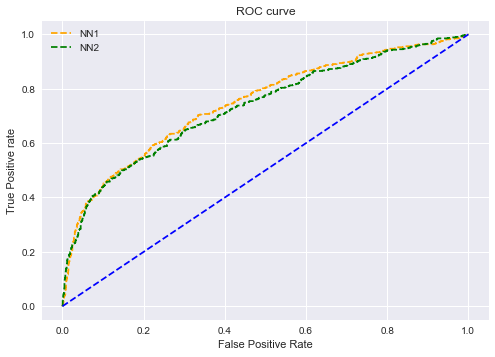

In [399]:
from sklearn.metrics import roc_curve

pred_prob1 = predictions
pred_prob2 = predictions_1
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,0], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,0], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='NN1')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='NN2')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

## Make predictions (on the provided test set)

Based on the results obtained and analyzed during the training and the validation phases, what are your (rather _personal_) expectations with respect to the performances of your model on the blind external test set? Briefly motivate your answer.

### Comment
Based on the validation results I expect the model to have a high precision and recall on the 0 class, but, at the same time, to score pretty low on the 1 class; the precision in particular will be very low.  
More specifically, the model is expected to find only 66% of all the observations that should be predicted as a 1 and, at the same time, only 38% of the instances classified with a value of 1 are actually expected to be correctly picked.  
The high accuracy value overall is therefore driven mostly by the model ability to correcly classify 0 values. This situation is probably caused by the general overfitting present and by the small amount of data available for training. In particular very few data with the 1 class are present, for this reason the model has yet to properly learn how to differentiate these observations from the one with a 0 class.  
Obviously this is not going to be an optimal model for classification. 

In [400]:
predictions_def = model.predict(x_predict)
predictions_def = (predictions_def > 0.5).astype(np.int8)

In [401]:
x_or_predict['predicted_default_next_month'] = predictions_def.tolist()
x_or_predict

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,predicted_default_next_month
0,2309,30000.0,1,2,2,25,0,0,0,0,...,12580.0,13716.0,14828.0,1500.0,2000.0,1500.0,1500.0,1500.0,2000.0,[0]
1,22405,150000.0,2,1,2,26,0,0,0,0,...,101581.0,77741.0,77264.0,4486.0,4235.0,3161.0,2647.0,2669.0,2669.0,[0]
2,23398,70000.0,2,3,1,32,0,0,0,0,...,69753.0,70111.0,70212.0,2431.0,3112.0,3000.0,2438.0,2500.0,2554.0,[0]
3,25059,130000.0,1,3,2,49,0,0,0,0,...,16898.0,11236.0,6944.0,1610.0,1808.0,7014.0,27.0,7011.0,4408.0,[0]
4,2665,50000.0,2,2,2,36,0,0,0,0,...,19574.0,20295.0,19439.0,2000.0,1500.0,1000.0,1800.0,0.0,1000.0,[0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2211,360000.0,2,1,2,27,1,-2,-1,-1,...,0.0,1271.0,179.0,0.0,830.0,0.0,1271.0,179.0,1970.0,[0]
5996,14145,500000.0,2,1,2,28,2,0,0,2,...,78070.0,78376.0,80912.0,6000.0,13151.0,0.0,3000.0,5000.0,10000.0,[0]
5997,23109,60000.0,2,1,1,28,0,0,0,0,...,50385.0,52045.0,52661.0,2100.0,2500.0,2500.0,2500.0,1600.0,1500.0,[0]
5998,25704,20000.0,2,1,2,29,1,-1,-1,-1,...,1364.0,600.0,0.0,2494.0,3967.0,1370.0,600.0,0.0,0.0,[0]


# OPTIONAL -- Export the predictions in the format indicated in the assignment release page.

In [402]:
np.savetxt(r'C:\Users\lucam\Desktop\Uni\Advanced Machine Learning\Assignment 1\Luca_Maggi_866654_score2.txt', predictions_def, fmt='%d')

# OPTIONAL -- Implement some regularization methods of your choice and make a comparison between (training/validation) performances of regularized models (also compare with the case of no regularization)

Attempts in this section will be taken into account, if well-enough done, to (at least partially) compensate for potential incorrectessness in the mandatory sections. 
On the other hand, any incorrectessness in _this_ section won't be taken into account in the final score.

### Comment
Two regularization methods are implemented in this section. These methods are especially good to reduce the overfit, therefore they are applied to both the model with a single hidden layer and to the one with two hidden layers.  
In general the L1 regularization technique is called Lasso and the L2 is called Ridge. The difference lies in the fact that the latter can shrink some features to almost zero asintotically, while the former can actaully remove some features, shrinking them to zero.  
For each one of the plots below the same model is regularized with both these techniques and the results are shown. In both cases the L2 norm stops after a lower number of epochs and, at the same time, provides better values in terms of accuracy and reduction in the loss functiom.  
The model with two hidden layers presents a much better fit than before, and the noise is drastically reduced. 
The main problem in both cases lies in the low accuracy: the first model presents a more stable value for this metric, but it can not achieve a value highter than 50%. The second model can reach up to 80% but its accuracy becomes very unstable and noisy.  

As a comparison between differet regularization techniques a classification report is printed for the same model with two hidden layers, first optimized with the L1 procedure, then with the other one. Countrary to what the plot might have suggested, all the values are remarkably similar.

As a way to compare all the models evaluated this far a ROC Curve is presented, according to this metric the best model is still the one with a single hidden layer and no regularization.

In [403]:
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt

In [474]:
n_epochs = 1000
batch_size = 78
es_1 = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20) 
es_2 = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)

In [476]:
# L1 regularization, one hidden layer model

model_l1 = Sequential()
model_l1.add(Dense(50, input_shape=(23,), activation = "relu", kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))

model_l1.add(Dense(1, activation = "sigmoid"))

model_l1.compile(optimizer = "sgd",
              loss = "binary_crossentropy",
              metrics = ["accuracy"]
              )

model_l1_history = model_l1.fit(x_train, y_train, batch_size=batch_size, 
                            epochs=n_epochs, validation_split = 0.2,  callbacks=[es_1])


Epoch 1/1000
346/346 [==============================] - 1s 2ms/step - loss: 2.0936 - accuracy: 0.6111 - val_loss: 2.1799 - val_accuracy: 0.0071
Epoch 2/1000
346/346 [==============================] - 0s 1ms/step - loss: 1.7191 - accuracy: 0.6308 - val_loss: 1.8808 - val_accuracy: 0.0290
Epoch 3/1000
346/346 [==============================] - 0s 1ms/step - loss: 1.4140 - accuracy: 0.6426 - val_loss: 1.5885 - val_accuracy: 0.0771
Epoch 4/1000
346/346 [==============================] - 0s 1ms/step - loss: 1.1652 - accuracy: 0.6561 - val_loss: 1.3389 - val_accuracy: 0.1386
Epoch 5/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.9709 - accuracy: 0.6619 - val_loss: 1.1757 - val_accuracy: 0.1300
Epoch 6/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.8303 - accuracy: 0.6610 - val_loss: 1.0724 - val_accuracy: 0.0924
Epoch 7/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.7337 - accuracy: 0.6578 - val_loss: 0.9829 - val_accuracy:

In [477]:
# L2 Regularization, one hidden layer model

model_l2 = Sequential()
model_l2.add(Dense(50, input_shape=(23,), activation = "relu", kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_l2.add(Dense(1, activation = "sigmoid"))

model_l2.compile(optimizer = "sgd",
              loss = "binary_crossentropy",
              metrics = ["accuracy"]
              )

model_l2_history = model_l2.fit(x_train, y_train, batch_size=batch_size, 
                            epochs=n_epochs, validation_split = 0.2, callbacks=[es_2])

Epoch 1/1000
346/346 [==============================] - 1s 2ms/step - loss: 0.9430 - accuracy: 0.6281 - val_loss: 1.2048 - val_accuracy: 0.0594
Epoch 2/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.8814 - accuracy: 0.6665 - val_loss: 1.1068 - val_accuracy: 0.2555
Epoch 3/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.8362 - accuracy: 0.6958 - val_loss: 1.1107 - val_accuracy: 0.2844
Epoch 4/1000
346/346 [==============================] - 1s 1ms/step - loss: 0.8008 - accuracy: 0.7108 - val_loss: 1.0648 - val_accuracy: 0.3362
Epoch 5/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.7719 - accuracy: 0.7197 - val_loss: 0.9797 - val_accuracy: 0.4160
Epoch 6/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.7476 - accuracy: 0.7269 - val_loss: 1.0091 - val_accuracy: 0.3870
Epoch 7/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.7263 - accuracy: 0.7309 - val_loss: 0.9889 - val_accuracy:

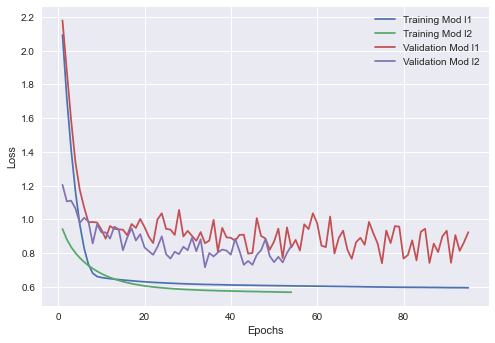

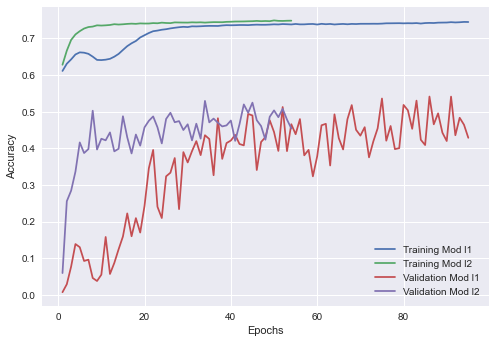

In [478]:
stopped_1 = es_1.stopped_epoch
stopped_2 = es_2.stopped_epoch


stopped_diff = stopped_1 - stopped_2

if stopped_diff < 0:
    stopped_tot = stopped_2
    x_plot = list(range(1,stopped_tot+2))
    x_plot_1 = list(range(1,stopped_tot+2+stopped_diff))
    def plot_history(network_history_1, network_history_2):
        plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(x_plot_1, network_history_1.history['loss'])
        plt.plot(x_plot, network_history_2.history['loss'])
        plt.plot(x_plot_1, network_history_1.history['val_loss'])    
        plt.plot(x_plot, network_history_2.history['val_loss'])
        plt.legend(['Training Mod l1', 'Training Mod l2', 'Validation Mod l1', 'Validation Mod l2'])

        plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.plot(x_plot_1, network_history_1.history['accuracy'])
        plt.plot(x_plot, network_history_2.history['accuracy'])
        plt.plot(x_plot_1, network_history_1.history['val_accuracy'])
        plt.plot(x_plot, network_history_2.history['val_accuracy'])
        plt.legend(['Training Mod l1', 'Training Mod l2', 'Validation Mod l1', 'Validation Mod l2'], loc='lower right')
        plt.show()

else:
    stopped_tot = stopped_1
    x_plot = list(range(1,stopped_tot+2))
    x_plot_2 = list(range(1,stopped_tot+2-stopped_diff))
    def plot_history(network_history_1, network_history_2):
        plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(x_plot, network_history_1.history['loss'])
        plt.plot(x_plot_2, network_history_2.history['loss'])
        plt.plot(x_plot, network_history_1.history['val_loss'])    
        plt.plot(x_plot_2, network_history_2.history['val_loss'])
        plt.legend(['Training Mod l1', 'Training Mod l2', 'Validation Mod l1', 'Validation Mod l2'])

        plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.plot(x_plot, network_history_1.history['accuracy'])
        plt.plot(x_plot_2, network_history_2.history['accuracy'])
        plt.plot(x_plot, network_history_1.history['val_accuracy'])
        plt.plot(x_plot_2, network_history_2.history['val_accuracy'])
        plt.legend(['Training Mod l1', 'Training Mod l2', 'Validation Mod l1', 'Validation Mod l2'], loc='lower right')
        plt.show()
        
plot_history(model_l1_history, model_l2_history)

In [480]:
es_1 = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 30) # aumentato a trenta o si fermava subito in un plateau temporaneo
es_2 = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)

In [481]:
# L1 regularization, two hidden layers model

model_l1_2 = Sequential()
model_l1_2.add(Dense(50, input_shape=(23,), activation = "relu", kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
model_l1_2.add(Dense(10, activation = "relu", kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
model_l1_2.add(Dense(1, activation = "sigmoid"))

model_l1_2.compile(optimizer = "sgd",
              loss = "binary_crossentropy",
              metrics = ["accuracy"]
              )

model_l1_2_history = model_l1_2.fit(x_train, y_train, batch_size=batch_size, 
                            epochs=n_epochs, validation_split = 0.2,  callbacks=[es_1])


Epoch 1/1000
346/346 [==============================] - 1s 2ms/step - loss: 2.8628 - accuracy: 0.6269 - val_loss: 2.9010 - val_accuracy: 0.0094
Epoch 2/1000
346/346 [==============================] - 0s 1ms/step - loss: 2.3528 - accuracy: 0.6289 - val_loss: 2.4318 - val_accuracy: 0.0245
Epoch 3/1000
346/346 [==============================] - 0s 1ms/step - loss: 1.9180 - accuracy: 0.6324 - val_loss: 2.0232 - val_accuracy: 0.0266
Epoch 4/1000
346/346 [==============================] - 0s 1ms/step - loss: 1.5500 - accuracy: 0.6310 - val_loss: 1.6935 - val_accuracy: 0.0214
Epoch 5/1000
346/346 [==============================] - 1s 1ms/step - loss: 1.2432 - accuracy: 0.6299 - val_loss: 1.3896 - val_accuracy: 0.0201
Epoch 6/1000
346/346 [==============================] - 0s 1ms/step - loss: 1.0030 - accuracy: 0.6271 - val_loss: 1.1869 - val_accuracy: 0.0000e+00
Epoch 7/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.8331 - accuracy: 0.6250 - val_loss: 1.0693 - val_accur

In [482]:
# L2 Regularization, two hidden layers model 

model_l2_2 = Sequential()
model_l2_2.add(Dense(50, input_shape=(23,), activation = "relu", kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_l2_2.add(Dense(10, activation = "relu", kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_l2_2.add(Dense(1, activation = "sigmoid"))

model_l2_2.compile(optimizer = "sgd",
              loss = "binary_crossentropy",
              metrics = ["accuracy"]
              )

model_l2_2_history = model_l2_2.fit(x_train, y_train, batch_size=batch_size, 
                            epochs=n_epochs, validation_split = 0.2, callbacks=[es_2])

Epoch 1/1000
346/346 [==============================] - 1s 1ms/step - loss: 1.1176 - accuracy: 0.6253 - val_loss: 1.3626 - val_accuracy: 0.0037
Epoch 2/1000
346/346 [==============================] - 0s 1ms/step - loss: 1.0421 - accuracy: 0.6331 - val_loss: 1.2552 - val_accuracy: 0.1171
Epoch 3/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.9762 - accuracy: 0.6722 - val_loss: 1.1891 - val_accuracy: 0.2728
Epoch 4/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.9223 - accuracy: 0.7021 - val_loss: 1.1327 - val_accuracy: 0.3521
Epoch 5/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.8774 - accuracy: 0.7139 - val_loss: 1.0874 - val_accuracy: 0.3979
Epoch 6/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.8392 - accuracy: 0.7217 - val_loss: 1.0939 - val_accuracy: 0.3753
Epoch 7/1000
346/346 [==============================] - 0s 1ms/step - loss: 0.8065 - accuracy: 0.7271 - val_loss: 1.0866 - val_accuracy:

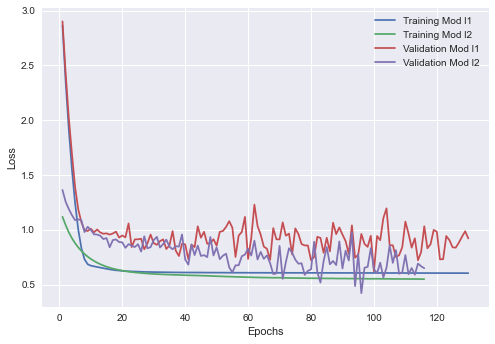

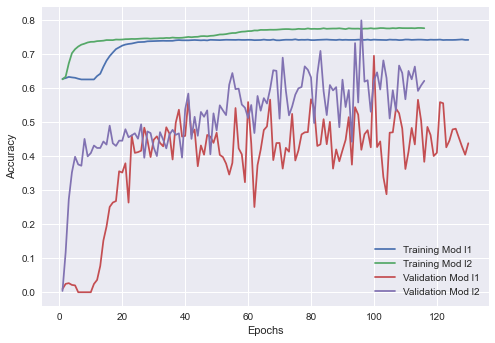

In [483]:
stopped_1 = es_1.stopped_epoch
stopped_2 = es_2.stopped_epoch


stopped_diff = stopped_1 - stopped_2

if stopped_diff < 0:
    stopped_tot = stopped_2
    x_plot = list(range(1,stopped_tot+2))
    x_plot_1 = list(range(1,stopped_tot+2+stopped_diff))
    def plot_history(network_history_1, network_history_2):
        plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(x_plot_1, network_history_1.history['loss'])
        plt.plot(x_plot, network_history_2.history['loss'])
        plt.plot(x_plot_1, network_history_1.history['val_loss'])    
        plt.plot(x_plot, network_history_2.history['val_loss'])
        plt.legend(['Training Mod l1', 'Training Mod l2', 'Validation Mod l1', 'Validation Mod l2'])

        plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.plot(x_plot_1, network_history_1.history['accuracy'])
        plt.plot(x_plot, network_history_2.history['accuracy'])
        plt.plot(x_plot_1, network_history_1.history['val_accuracy'])
        plt.plot(x_plot, network_history_2.history['val_accuracy'])
        plt.legend(['Training Mod l1', 'Training Mod l2', 'Validation Mod l1', 'Validation Mod l2'], loc='lower right')
        plt.show()

else:
    stopped_tot = stopped_1
    x_plot = list(range(1,stopped_tot+2))
    x_plot_2 = list(range(1,stopped_tot+2-stopped_diff))
    def plot_history(network_history_1, network_history_2):
        plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(x_plot, network_history_1.history['loss'])
        plt.plot(x_plot_2, network_history_2.history['loss'])
        plt.plot(x_plot, network_history_1.history['val_loss'])    
        plt.plot(x_plot_2, network_history_2.history['val_loss'])
        plt.legend(['Training Mod l1', 'Training Mod l2', 'Validation Mod l1', 'Validation Mod l2'])

        plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.plot(x_plot, network_history_1.history['accuracy'])
        plt.plot(x_plot_2, network_history_2.history['accuracy'])
        plt.plot(x_plot, network_history_1.history['val_accuracy'])
        plt.plot(x_plot_2, network_history_2.history['val_accuracy'])
        plt.legend(['Training Mod l1', 'Training Mod l2', 'Validation Mod l1', 'Validation Mod l2'], loc='lower right')
        plt.show()
        
plot_history(model_l1_2_history, model_l2_2_history)

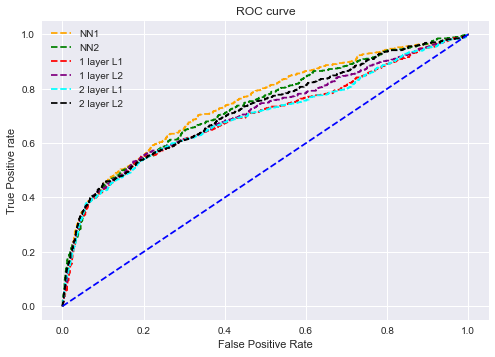

In [485]:
from sklearn.metrics import roc_curve

pred_prob1 = predictions
pred_prob2 = predictions_1
pred_prob_l1 = model_l1.predict(x_test)
pred_prob_l2 = model_l2.predict(x_test)
pred_prob_l1_2_layer = model_l1_2.predict(x_test)
pred_prob_l2_2_layer = model_l2_2.predict(x_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,0], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,0], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob_l1[:,0], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob_l2[:,0], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(y_test, pred_prob_l1_2_layer[:,0], pos_label=1)
fpr6, tpr6, thresh6 = roc_curve(y_test, pred_prob_l2_2_layer[:,0], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='NN1')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='NN2')

plt.plot(fpr3, tpr3, linestyle='--',color='red', label='1 layer L1')
plt.plot(fpr4, tpr4, linestyle='--',color='purple', label='1 layer L2')
plt.plot(fpr5, tpr5, linestyle='--',color='cyan', label='2 layer L1')
plt.plot(fpr6, tpr6, linestyle='--',color='black', label='2 layer L2')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [488]:
predictions_int_2 = (pred_prob_l1_2_layer > 0.5).astype(np.int8)
print(classification_report(predictions_int_2, y_test))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      2035
           1       0.40      0.60      0.48       365

    accuracy                           0.80      2400
   macro avg       0.66      0.72      0.68      2400
weighted avg       0.84      0.80      0.82      2400



In [489]:
predictions_int_3 = (pred_prob_l2_2_layer > 0.5).astype(np.int8)
print(classification_report(predictions_int_3, y_test))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      2054
           1       0.40      0.63      0.49       346

    accuracy                           0.81      2400
   macro avg       0.66      0.74      0.69      2400
weighted avg       0.85      0.81      0.83      2400

